In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

RSEED = 15
c = ['#cbc0d3', '#efd3d7', '#feeafa', '#dee2ff', '#8e9aaf']
c2 = ['#efd3d7', '#ecccd0', '#eac6cb', '#e9c2c7', '#e7bcc2', '#e5b7bd', '#e3b1b8', '#e1aeb5', '#dfa7af', '#dea3ab', '#dc9fa8', '#da9aa3', '#d8949e', '#d7929c']
from sklearn import set_config
set_config(display='diagram')

In [2]:
bcn = pd.read_csv('../data/df_modelling.csv')

In [3]:
bcn.head()

,Unnamed: 0,id,name,description,neighborhood_overview,picture_url,host_id,host_name,host_since,host_location,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,host_type,suspicious_or_not
0,0,13977576,Habitación individual es Barcelona,Mi alojamiento es bueno para aventureros y via...,NaN,https://a0.muscache.com/pictures/7a6e9767-bd4e...,64903899,Carolina,2016-03-29,"Paris, France",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,private,1
1,1,42105584,Habitación M&D,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/7342e586-6ea5...,333969184,Midian,2020-02-06,"Barcelona, Spain",...,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,private,1
2,2,33727898,Spacious and bright apartment next to Plaza Es...,Hi friends! Welcome to this apartment located ...,The apartment is located in the Eixample quart...,https://a0.muscache.com/pictures/44066458-5997...,251710733,Magda,2019-03-28,NaN,...,4.97,4.97,5.00,5.00,4.83,4.73,HUTB-008684,f,private,1
3,3,44995311,"Single Room, City Center, Private Bathroom",Goya Hostel is a hostel located in the center ...,"The Eixample, which translates as ""widening"" b...",https://a0.muscache.com/pictures/af651bc2-8dff...,363074093,Hostal,2020-08-18,"Barcelona, Spain",...,4.91,4.73,4.91,4.64,4.91,4.73,HUTB-265656,t,commercial,0
4,4,15763812,HABITACIÓN PLAZA ESPAÑA,"Lugares de interés: Poble Espanyol, CaixaForum...",NaN,https://a0.muscache.com/pictures/1bccbbbc-4b78...,101927904,James,2016-10-31,"Barcelona, Spain",...,4.90,4.94,4.96,4.67,4.88,4.60,Exempt,t,private,1


In [4]:
missing = pd.DataFrame(bcn.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/bcn.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
name,6,0.05
description,55,0.49
neighborhood_overview,4480,39.51
host_name,2,0.02
host_since,2,0.02
host_location,2502,22.06
host_about,4075,35.93
host_response_time,2048,18.06
host_response_rate,2048,18.06
host_acceptance_rate,1685,14.86


In [5]:
#drop columns with all NaN values
df_bl = bcn.drop(['bathrooms', 'calendar_updated'], axis=1)

In [6]:
#drop some columns which we won't use
df_bl.drop(['Unnamed: 0', 'id', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_name', 'host_location',
       'host_about', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'bathrooms_text', 'beds', 'amenities', 'host_total_listings_count', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_verifications' ], axis=1, inplace=True)

In [7]:
#check if those with NaN in many host related columns are always the same two
host_nans = df_bl[df_bl['host_since'].isna()]
host_nans

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,...,bedrooms,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,license,instant_bookable,host_type,suspicious_or_not
3465,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Eixample,Private room,...,1.0,$50.00,2,1125,t,1,NaN,f,private,1
11104,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Les Corts,Private room,...,1.0,$50.00,1,1125,t,0,NaN,f,private,1


In [8]:
# since they are, we delete them
df_bl=df_bl.dropna(subset=['host_since'])

## change some dtypes

In [9]:
# hoste_since to datetime
df_bl['host_since']= pd.to_datetime(df_bl['host_since'])

In [10]:
# price to float
df_bl['price'] = df_bl['price'].str[1:]
df_bl['price'] = df_bl['price'].str.replace(',','')
df_bl['price'] = pd.to_numeric(df_bl['price'])

In [11]:
# host_response_rate and host_acceptance_rate to float
df_bl['host_response_rate'] = df_bl['host_response_rate'].str.rstrip("%").astype(float)/100
df_bl['host_acceptance_rate'] = df_bl['host_acceptance_rate'].str.rstrip("%").astype(float)/100

In [12]:
# some boolean to 0/1
le = LabelEncoder()
df_bl['host_is_superhost'] = le.fit_transform(df_bl['host_is_superhost'])
df_bl['host_has_profile_pic'] = le.fit_transform(df_bl['host_has_profile_pic'])
df_bl['host_identity_verified'] = le.fit_transform(df_bl['host_identity_verified'])
df_bl['has_availability'] = le.fit_transform(df_bl['has_availability'])
df_bl['instant_bookable'] = le.fit_transform(df_bl['instant_bookable'])

In [13]:
# host_listings_count as int
df_bl['host_listings_count'] = df_bl['host_listings_count'].astype(int)

## train test split

In [14]:
# separate target variable
X = df_bl.drop('suspicious_or_not', axis=1)
y = df_bl['suspicious_or_not']

In [15]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED, stratify = y)

In [16]:
X_train.head(10)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,accommodates,bedrooms,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,license,instant_bookable,host_type
9092,2017-07-04,NaN,NaN,NaN,0,1,1,0,Sant Andreu,Private room,2,1.0,39.0,3,7,1,10,NaN,1,private
8213,2023-01-11,within a few hours,1.00,NaN,0,2,1,1,Eixample,Entire home/apt,2,1.0,47.0,32,364,1,0,NaN,0,commercial
898,2019-10-01,within an hour,1.00,0.99,0,4,1,1,Ciutat Vella,Entire home/apt,10,4.0,291.0,2,1125,1,51,HUTB-052261,1,commercial
2444,2013-03-25,within an hour,0.91,0.89,0,39,1,1,Ciutat Vella,Entire home/apt,2,1.0,181.0,1,1125,1,17,HUTB-002676,0,commercial
9477,2010-11-26,within an hour,0.99,1.00,0,250,1,1,Eixample,Entire home/apt,6,3.0,178.0,3,1125,1,155,HUTB-013053,1,commercial
5429,2020-01-01,NaN,NaN,1.00,1,2,1,1,Sarrià-Sant Gervasi,Private room,2,1.0,61.0,1,1125,1,11,Exempt,0,private
7179,2016-06-17,within an hour,1.00,0.77,0,3,1,1,Horta-Guinardó,Private room,3,1.0,25.0,32,330,1,6,NaN,0,private
1700,2012-02-13,within an hour,1.00,0.97,0,30,1,1,Sants-Montjuïc,Entire home/apt,5,2.0,133.0,3,200,1,2,HUTB-004679,1,commercial
4664,2022-09-07,within an hour,0.98,1.00,0,18,1,1,Ciutat Vella,Private room,1,1.0,33.0,32,365,1,13,Exempt,1,private
728,2013-04-13,within a day,1.00,0.40,0,1,1,0,Ciutat Vella,Private room,2,1.0,39.0,1,356,1,4,NaN,0,private


In [17]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9070, 20)
X_test shape: (2268, 20)
y_train shape: (9070,)
y_test shape: (2268,)


## Preprocessing

<Axes: >

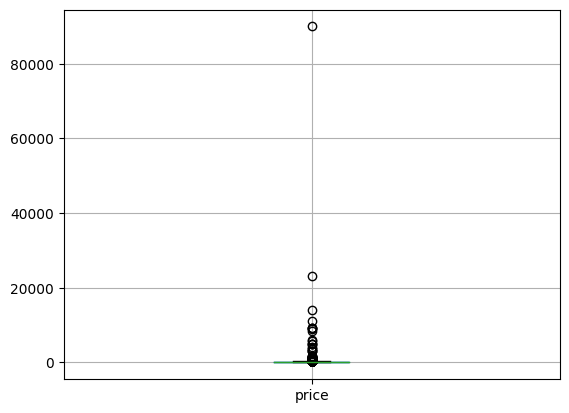

In [18]:
# find outliers
X_train.boxplot('price')

In [19]:
# find outliers
X_train.boxplot('minimum_nights')

<Axes: >

In [20]:
# delete price outliers with IQR method

# find IQR of train data
for x in ['price']:
    q75, q25 = np.percentile(X_train.loc[:,x],[75,25])
    intr_qr = q75-q25
    maxp = q75+(1.5*intr_qr)
    minp = q25-(1.5*intr_qr)

# apply on train data    
    X_train.loc[X_train[x] < minp,x] = np.nan
    X_train.loc[X_train[x] > maxp,x] = np.nan
    
# apply on test data    
    X_test.loc[X_test[x] < minp,x] = np.nan
    X_test.loc[X_test[x] > maxp,x] = np.nan

In [21]:
# delete minimum_nights outliers with IQR method

# find IQR of train data
for x in ['minimum_nights']:
    q75, q25 = np.percentile(X_train.loc[:,x],[75,25])
    intr_qr = q75-q25
    maxn = q75+(1.5*intr_qr)
    minn = q25-(1.5*intr_qr)

# apply on train data  
    X_train.loc[X_train[x] < minn,x] = np.nan
    X_train.loc[X_train[x] > maxn,x] = np.nan

# apply on test data    
    X_test.loc[X_test[x] < minn,x] = np.nan
    X_test.loc[X_test[x] > maxn,x] = np.nan

In [22]:
# columns to impute by mean
num_col_mean = ['host_response_rate', 'host_acceptance_rate']

# columns to impute by median
num_col_median = ['bedrooms', 'price', 'minimum_nights', 'maximum_nights']

# categorical columns to impute
cat_col_missing = ['host_response_time']
cat_col_no = ['license']

In [23]:
# create values dict for imputation of missing values
values_dict = {}

# find median of train data and apply on train and test data
for col in num_col_median:
    values_dict[col] = X_train[col].median()
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

In [24]:
# find mean of train data and apply on train and test data
for col in num_col_mean:
    values_dict[col] = X_train[col].mean()
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

In [25]:
# add new category 'missing' to train and test data
for col in cat_col_missing:
    values_dict[col] = 'missing'
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

In [26]:
# add new category 'no' to train and test data
for col in cat_col_no:
    values_dict[col] = 'no'
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

## Handle license column

In [27]:
def license(license):
    if 'HUTB' in license:
        return 1
    if 'HB' in license:
        return 1
    if 'AJ' in license:
        return 1
    elif 'exempt' in license.lower():
        return 0
    else:
        return 0

In [28]:
X_train['license'] = X_train.apply(lambda row: license(row['license']), axis=1)
X_test['license'] = X_test.apply(lambda row: license(row['license']), axis=1)

In [29]:
X_train.head(10)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,accommodates,bedrooms,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,license,instant_bookable,host_type
9092,2017-07-04,missing,0.943556,0.897679,0,1,1,0,Sant Andreu,Private room,2,1.0,39.0,3.0,7,1,10,0,1,private
8213,2023-01-11,within a few hours,1.000000,0.897679,0,2,1,1,Eixample,Entire home/apt,2,1.0,47.0,32.0,364,1,0,0,0,commercial
898,2019-10-01,within an hour,1.000000,0.990000,0,4,1,1,Ciutat Vella,Entire home/apt,10,4.0,291.0,2.0,1125,1,51,1,1,commercial
2444,2013-03-25,within an hour,0.910000,0.890000,0,39,1,1,Ciutat Vella,Entire home/apt,2,1.0,181.0,1.0,1125,1,17,1,0,commercial
9477,2010-11-26,within an hour,0.990000,1.000000,0,250,1,1,Eixample,Entire home/apt,6,3.0,178.0,3.0,1125,1,155,1,1,commercial
5429,2020-01-01,missing,0.943556,1.000000,1,2,1,1,Sarrià-Sant Gervasi,Private room,2,1.0,61.0,1.0,1125,1,11,0,0,private
7179,2016-06-17,within an hour,1.000000,0.770000,0,3,1,1,Horta-Guinardó,Private room,3,1.0,25.0,32.0,330,1,6,0,0,private
1700,2012-02-13,within an hour,1.000000,0.970000,0,30,1,1,Sants-Montjuïc,Entire home/apt,5,2.0,133.0,3.0,200,1,2,1,1,commercial
4664,2022-09-07,within an hour,0.980000,1.000000,0,18,1,1,Ciutat Vella,Private room,1,1.0,33.0,32.0,365,1,13,0,1,private
728,2013-04-13,within a day,1.000000,0.400000,0,1,1,0,Ciutat Vella,Private room,2,1.0,39.0,1.0,356,1,4,0,0,private


### Building pipelines

In [30]:
cat_features = list(X_train.columns[X_train.dtypes==object])
cat_features

['host_response_time',
 'neighbourhood_group_cleansed',
 'room_type',
 'host_type']

In [31]:
num_features = list(X_train.columns[X_train.dtypes!=object])
num_features.remove('host_since')
num_features

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'number_of_reviews',
 'license',
 'instant_bookable']

In [32]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

In [33]:
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [34]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

## Logistic Regression

In [35]:
pipe_logreg_bl = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [36]:
y_train_predicted_bl = cross_val_predict(pipe_logreg_bl, X_train, y_train, cv=5)

In [37]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_bl)))

Cross validation scores:
-------------------------
Accuracy: 0.87
Recall: 0.84
Precision: 0.87


In [38]:
param_logreg_bl = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag'],
               }

grid_logreg_bl = GridSearchCV(pipe_logreg_bl, param_grid=param_logreg_bl, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

In [39]:
grid_logreg_bl.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/johannakruger/neuefische/Modellbauer/.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ['liblinear', 'lbfgs', 'sag']},
             scoring='precision', verbose=5)

In [40]:
print('Best score:\n{:.2f}'.format(grid_logreg_bl.best_score_))
print("Best parameters:\n{}".format(grid_logreg_bl.best_params_))

Best score:
0.87
Best parameters:
{'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [41]:
baselinemodel = grid_logreg_bl.best_estimator_
baselinemodel

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('logreg',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [42]:
y_test_predicted_bl = baselinemodel.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_bl)))

Accuracy: 0.86
Recall: 0.81
Precision: 0.87


In [43]:
%matplotlib inline
cfm_bl = confusion_matrix(y_test, y_test_predicted_bl)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_bl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_bl.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_bl, annot=labels, fmt='', cmap=c2);

In [44]:
y_test_proba_bl = baselinemodel.predict_proba(X_test)

In [45]:
y_test_proba_bl = y_test_proba_bl[:,1]

In [46]:
bl_auc = roc_auc_score(y_test, y_test_proba_bl)
bl_auc

0.9410523115880258

In [47]:
fprbl, tprbl, thresholdsbl = roc_curve(y_test, y_test_proba_bl)

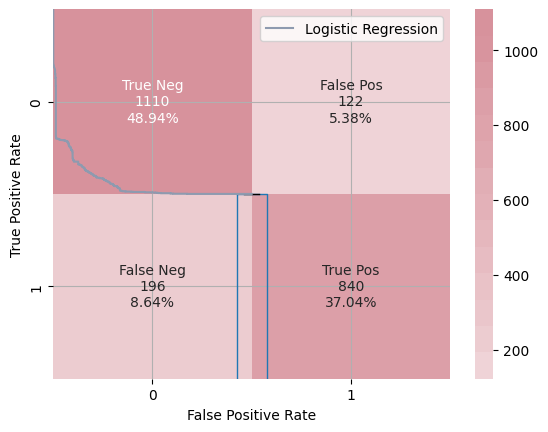

In [48]:
%matplotlib inline

from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, label='Logistic Regression', color='#8e9aaf')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# Modelling

## Random Forest

In [49]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestClassifier(random_state=RSEED))
])

y_train_predicted_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_rf)))

Cross validation scores:
-------------------------
Accuracy: 0.98
Recall: 0.99
Precision: 0.97


In [50]:
param_rf_all = {'randfor__n_estimators':[100, 500, 1000, 1500, 2000],
                'randfor__min_samples_split': [2, 5, 10, 15, 20],
                'randfor__max_depth': [10,20,50,80,100],
                'randfor__max_features': ['auto', 'sqrt'],
                'randfor__min_samples_leaf' : [1,2,4],
                'randfor__bootstrap': [True, False],
              }

Best parameters
{'randfor__bootstrap': True, 'randfor__max_depth': 80, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 5, 'randfor__n_estimators': 100}

In [51]:
param_rf_best = {'randfor__n_estimators':[1500],
                'randfor__min_samples_split': [2],
                'randfor__max_depth': [50],
                'randfor__max_features': ['auto'],
                'randfor__min_samples_leaf' : [1],
                'randfor__bootstrap': [False],
             }

In [52]:
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf_best, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('randfor',
                                        RandomForestClassifier(random_state=15))]),
             n_jobs=-1,
             param_grid={'randfor__bootstrap': [False],
                         'randfor__max_depth': [50],
                         'randfor__max_features': ['auto'],
                         'randfor__min_samples_leaf': [1],
                         'randfor__min_samples_split': [2],
                         'randfor__n_estimators': [1500]},
             scoring='precision', verbose=5)

In [53]:
print('Best score:\n{:.2f}'.format(grid_rf.best_score_))
print("Best parameters:\n{}".format(grid_rf.best_params_))

Best score:
0.98
Best parameters:
{'randfor__bootstrap': False, 'randfor__max_depth': 50, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 1, 'randfor__min_samples_split': 2, 'randfor__n_estimators': 1500}


In [54]:
randomforest = grid_rf.best_estimator_
randomforest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        max_features='auto', n_estimators=1500,
                                        random_state=15))])

In [55]:
pipe_rf_final = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestClassifier(n_estimators = 1500, min_samples_split = 2, max_depth = 50, max_features = 'auto', min_samples_leaf = 1, bootstrap = False, random_state=RSEED))
])

In [56]:
pipe_rf_final.fit(X_train, y_train)

/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        max_features='auto', n_estimators=1500,
                                        random_state=15))])

In [57]:
y_test_predicted_rf_final = pipe_rf_final.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_rf_final)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_rf_final)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_rf_final)))

Accuracy: 0.99
Recall: 0.99
Precision: 0.98


In [58]:
pipe_rf_final.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('std_scaler',
                                                    StandardScaler())]),
                                   ['host_response_rate', 'host_acceptance_rate',
                                    'host_is_superhost', 'host_listings_count',
                                    'host_has_profile_pic',
                                    'host_identity_verified', 'accommodates',
                                    'bedrooms', 'price', 'minimum_nights',
                                    'maximum_nights', 'has_availability',
                                    'number_of_reviews', 'license',
                                    'instant_bookable']),
                                  ('cat',
                                   Pipeline(steps=[('1hot',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                             

In [59]:
pipe_rf_final.steps[1][1].feature_importances_

array([0.01951348, 0.02408476, 0.00720364, 0.10766863, 0.00069156,
       0.00277516, 0.02120939, 0.01028518, 0.05291788, 0.19684546,
       0.01893237, 0.00040881, 0.03664728, 0.19752961, 0.00576861,
       0.00046767, 0.01048957, 0.00319581, 0.00346809, 0.00625768,
       0.00500874, 0.00343849, 0.00227532, 0.00107269, 0.00123268,
       0.00075177, 0.00072106, 0.00216054, 0.00241418, 0.00167182,
       0.02285869, 0.00048254, 0.03060983, 0.00057545, 0.09583038,
       0.10253517])

In [60]:
pipe_rf_final.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('std_scaler',
                                                    StandardScaler())]),
                                   ['host_response_rate', 'host_acceptance_rate',
                                    'host_is_superhost', 'host_listings_count',
                                    'host_has_profile_pic',
                                    'host_identity_verified', 'accommodates',
                                    'bedrooms', 'price', 'minimum_nights',
                                    'maximum_nights', 'has_availability',
                                    'number_of_reviews', 'license',
                                    'instant_bookable']),
                                  ('cat',
                                   Pipeline(steps=[('1hot',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                             

In [61]:
pipe_rf_final[0].output_indices_

{'num': slice(0, 15, None),
 'cat': slice(15, 36, None),
 'remainder': slice(0, 0, None)}

In [62]:
encoded_cat_features = pipe_rf_final['preprocessor'].transformers_[1][1]\
    ['1hot'].get_feature_names_out(cat_features)

In [63]:
feature_names = np.insert(encoded_cat_features,0, num_features)

<BarContainer object of 36 artists>

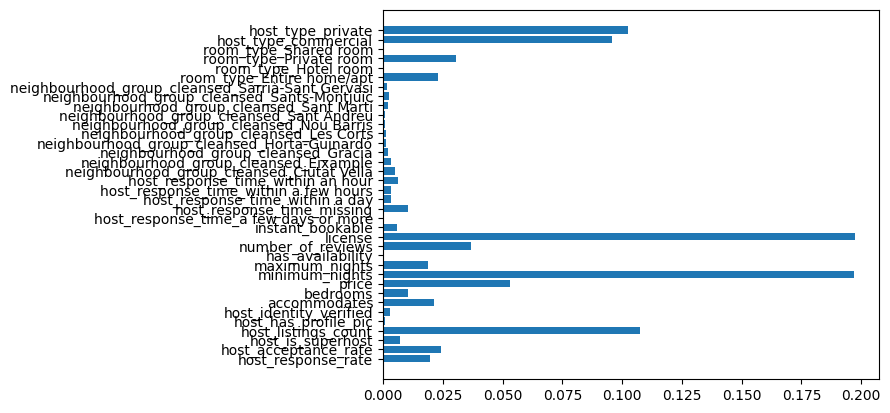

In [64]:
plt.barh(feature_names, pipe_rf_final.steps[1][1].feature_importances_)

In [65]:
y_test_predicted_rf_final = randomforest.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_rf_final)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_rf_final)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_rf_final)))

Accuracy: 0.99
Recall: 0.99
Precision: 0.98


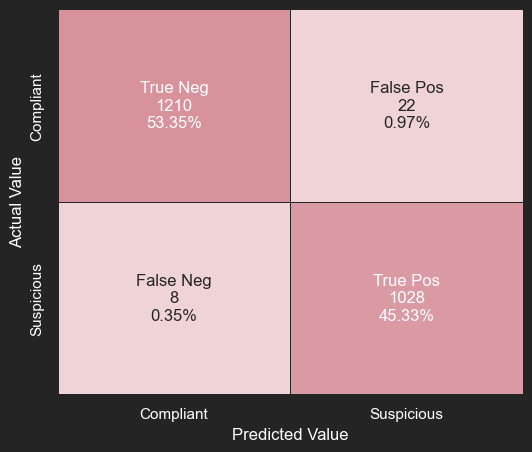

In [67]:
%matplotlib inline
cfm_rf_final = confusion_matrix(y_test, y_test_predicted_rf_final)
fig = plt.figure()
fig.set_size_inches(6,5)
sns.set(rc={'axes.facecolor':'#242424','figure.facecolor':'#242424', 'text.color':'white'})
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_rf_final.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_rf_final.flatten()/np.sum(cfm_rf_final)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
x_axis_labels = ['Compliant', 'Suspicious'] 
y_axis_labels = ['Compliant', 'Suspicious'] 
sns.heatmap(cfm_rf_final, annot=labels, fmt='', cmap=c2, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=.5, cbar = False, linecolor='#242424')
# ax.set_title('Confusion Matrix')
xlabel = plt.xlabel('Predicted Value')
ylabel = plt.ylabel('Actual Value')
xlabel.set_color("white")
ylabel.set_color("white")
ax.tick_params(colors='white')
plt.show();

In [57]:
y_test_proba_rf = randomforest.predict_proba(X_test)
y_test_proba_rf = y_test_proba_rf[:,1]
rf_auc = roc_auc_score(y_test, y_test_proba_rf)
fprrf, tprrf, thresholdsrf = roc_curve(y_test, y_test_proba_rf)

In [58]:
rf_auc

0.9983860251717395

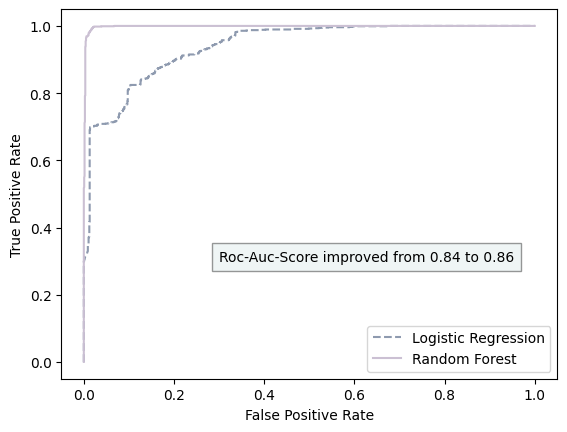

In [59]:
from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, linestyle='--', label='Logistic Regression', color='#8e9aaf')
pyplot.plot(fprrf, tprrf, label='Random Forest', color = '#cbc0d3')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.3,0.3,'Roc-Auc-Score improved from 0.84 to 0.86', bbox={
        'facecolor': '#D9E8E8', 'alpha': 0.4, 'pad': 5})
pyplot.legend()
pyplot.show()

## XGB Classifier

In [60]:
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(random_state=RSEED))
])

y_train_predicted_xgb = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_rf)))

Cross validation scores:
-------------------------
Accuracy: 0.98
Recall: 0.99
Precision: 0.97


In [61]:
param_xgb_all = {
    "xgb__learning_rate" : [0.05,0.15,0.30],
    "xgb__max_depth" : [ 3, 6, 10, 15],
    "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
    "xgb__gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "xgb__colsample_bytree" : [ 0.3,  0.5 , 0.7 ],
    "xgb__subsample" : [0.5, 1],
    "xgb__scale_pos_weight" : [1, 2]
    }

In [62]:
param_xgb_best = {
    "xgb__learning_rate" : [0.05],
    "xgb__max_depth" : [10],
    "xgb__min_child_weight" : [5],
    "xgb__gamma": [ 0.1],
    "xgb__colsample_bytree" : [0.5],
    "xgb__subsample" : [0.5],
    "xgb__scale_pos_weight" : [1]
    }

In [75]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb_best, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__scale_pos_weight=1, xgb__subsample=1;, score=0.968 total time=   1.0s
[CV 3/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__scale_pos_weight=2, xgb__subsample=1;, score=0.945 total time=   0.9s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=3, xgb__scale_pos_weight=1, xgb__subsample=1;, score=0.962 total time=   0.9s
[CV 4/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=3, xgb__scale_pos_weight=2, xgb__subsample=0.5;, score=0.955 total time=   1.1s
[CV 2/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__scale_pos_weig

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=15, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.5], 'xgb__gamma': [0.1],
                         'xgb__learning_rate': [0.05], 'xgb__max_depth': [10],
                         'xgb__min_child_weight': [5],
                         'xgb__scale_pos_weight': [1],
                         'xgb__subsample': [0.5]},
             scoring='precision', verbose=5)

In [64]:
print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))

Best score:
0.98
Best parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__gamma': 0.3, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 15, 'xgb__min_child_weight': 1, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 1}


In [65]:
XGBOOST = grid_xgb.best_estimator_
XGBOOST

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number...
                               feature_types=None, gamma=0.3, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=15, ...))])

In [66]:
y_test_predicted_xgb = XGBOOST.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_xgb)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_xgb)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_xgb)))

Accuracy: 0.98
Recall: 0.98
Precision: 0.98


## KNN

In [70]:
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

y_train_predicted_knn = cross_val_predict(pipe_knn, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_knn)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_knn)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_knn)))

/Users/johannakruger/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/johannakruger/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and

Cross validation scores:
-------------------------
Accuracy: 0.87
Recall: 0.88
Precision: 0.85


/Users/johannakruger/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## Decision Tree

In [71]:
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=RSEED))
])

y_train_predicted_tree = cross_val_predict(pipe_tree, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_tree)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_tree)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_tree)))

Cross validation scores:
-------------------------
Accuracy: 0.98
Recall: 0.98
Precision: 0.98


In [72]:
param_tree_all = {'tree__criterion':['gini', 'entropy'],
                'tree__max_depth':[2,4,6,8,10,12]
              }

In [73]:
param_tree_best = {'tree__criterion':['entropy'],
                'tree__max_depth':[6]
              }

In [74]:
grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree_all, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                                          'instant_bookable']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('tree',
                                        DecisionTreeClassifier(max_depth=15,
                                                               random_state=15))]),
             n_jobs=-1,
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [2, 4, 6, 8, 10, 12]},
             scoring='precision', verbose=5)

In [75]:
print('Best score:\n{:.2f}'.format(grid_tree.best_score_))
print("Best parameters:\n{}".format(grid_tree.best_params_))

Best score:
0.98
Best parameters:
{'tree__criterion': 'gini', 'tree__max_depth': 12}


In [76]:
Tree = grid_tree.best_estimator_
Tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('tree',
                 DecisionTreeClassifier(max_depth=12, random_state=15))])

In [77]:
y_test_predicted_tree = Tree.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_tree)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_tree)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_tree)))

Accuracy: 0.98
Recall: 0.98
Precision: 0.98


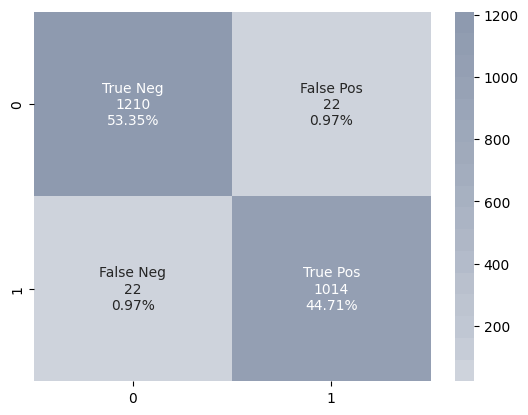

In [78]:
cfm_tree = confusion_matrix(y_test, y_test_predicted_tree)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_tree.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_tree.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_tree, annot=labels, fmt='', cmap=c2);